# 1. Brand and MBTI Mapping
This code analyzes the relationship between brands and MBTI types by vectorizing text data, predicting brand preferences with a logistic regression model, performing sentiment analysis, and visualizing the results with a heatmap.

MBTI           ENFJ      ENFP  ENTJ      ENTP      INFJ      INFP      INTJ  \
brand                                                                         
Cartier         NaN  0.467424  -0.2  0.236111  0.190659  0.412853  0.169156   
Chanel          NaN  0.245455   NaN  0.000000  0.355093  0.420816  0.232392   
Dior            NaN  0.304167   NaN       NaN  0.175000  0.235141  0.178650   
Gucci           NaN  0.206629   NaN  1.000000  0.221875  0.482831  0.398216   
Louis Vuitton   NaN  0.000000   NaN       NaN  0.076431  0.484255  0.190278   
Prada           NaN  0.478571   NaN  0.766667  0.251429  0.160066  0.082335   
Ralph Lauren    0.7  0.375000   NaN  0.595000  0.474314  0.320370  0.150112   
Rolex           NaN  0.208333   NaN       NaN  0.230985  0.398750  0.095684   
Tiffany         NaN       NaN   NaN  0.000000  0.230208  0.363710  0.053488   
Versace         NaN       NaN   NaN  0.000000  0.170000  0.215278  0.132357   

MBTI               INTP      ISFP  ISTP  
brand    

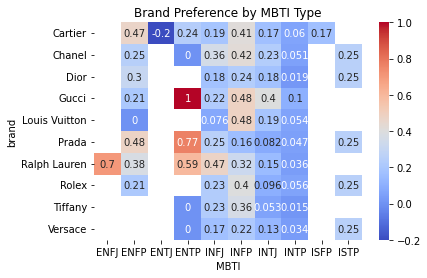

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/final_dataset_with_mbti_predictions.csv')
#handle missing values in the 'cleaned_text' column by replacing NaNs with an empty string
df['cleaned_text'] = df['cleaned_text'].fillna('')

#vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])

# map brand names to numerical labels
df['brand_label'] = df['brand'].astype('category').cat.codes

#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['brand_label'], test_size=0.2, random_state=42)

#train a Logistic Regression model to predict brands
model = LogisticRegression()
model.fit(X_train, y_train)

# make predictions and evaluate the model
predictions = model.predict(X_test)

# perform sentiment analysis on the cleaned text data.
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# create a crosstab of brand preferences by MBTI type with average sentiment.
brand_mbti_crosstab = pd.crosstab(df['brand'], df['MBTI'], values=df['sentiment'], aggfunc='mean')
print(brand_mbti_crosstab)

#visualize the relationship between brands and MBTI types using a heatmap.
sns.heatmap(brand_mbti_crosstab, annot=True, cmap='coolwarm')
plt.title('Brand Preference by MBTI Type')
plt.show()

#create a crosstab of brand preferences by MBTI type.
brand_mbti_crosstab = pd.crosstab(df['brand'], df['MBTI'])
brand_mbti_crosstab.to_csv('data/brand_mbti_mapping.csv')


# 2. Predicting MBTI, Recommending Brands, and Visualizing Sentiment
This script predicts the user's MBTI type based on text input, recommends relevant brands, performs sentiment analysis, and visualizes the sentiment as a color.

Predicted MBTI Type: INFP
Recommended Brands: Gucci
Sentiment Polarity: 0.5
Sentiment Subjectivity: 0.6
Extracted Topics: luxury love high


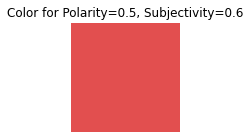

In [2]:
import joblib
import pandas as pd
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import colorsys

# Load the pre-trained MBTI prediction model and TF-IDF vectorizer
mbti_model = joblib.load('/Users/yinshuodi/Desktop/code/mbti_linear_svc_model.pkl')
vectorizer = joblib.load('/Users/yinshuodi/Desktop/code/tfidf_vectorizer.pkl')

# Load the brand and MBTI type mapping data
brand_mbti_mapping = pd.read_csv('/Users/yinshuodi/Desktop/code/data/brand_mbti_mapping.csv')

# Load the LabelEncoder for converting predicted MBTI types from numeric to string
label_encoder = joblib.load('/Users/yinshuodi/Desktop/code/label_encoder.pkl')

# Perform sentiment analysis on the input text
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Perform LDA topic modeling on the input text
def extract_topics(text, n_topics=1, n_words=3):
    count_vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words='english')
    X_counts = count_vectorizer.fit_transform([text])
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X_counts)
    feature_names = count_vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        topics.append(" ".join([feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]))
    return topics

# Recommend a brand based on the user's input
def recommend_brand(user_input, model, vectorizer, brand_mapping, label_encoder):
    # Transform the user's input text into a vector
    user_input_vectorized = vectorizer.transform([user_input])
    
    # Predict the MBTI type (numerical) using the model
    predicted_mbti_num = model.predict(user_input_vectorized)[0]
    
    # Convert the numerical MBTI type to a string using the LabelEncoder
    predicted_mbti = label_encoder.inverse_transform([predicted_mbti_num])[0]
    
    # Check if the predicted MBTI type is in the brand mapping columns
    if predicted_mbti not in brand_mapping.columns:
        raise ValueError(f"Predicted MBTI type {predicted_mbti} is not in the brand mapping columns.")
    
    # Retrieve recommended brands based on the predicted MBTI type
    recommended_brands = brand_mapping[['brand', predicted_mbti]].sort_values(by=predicted_mbti, ascending=False)['brand'].values
    
    return predicted_mbti, recommended_brands

# Map sentiment analysis results to a color
def sentiment_to_color(polarity, subjectivity):
    lightness = 0.3 + (polarity + 1) / 2 * 0.4  # Adjust lightness based on polarity
    saturation = 0.3 + subjectivity * 0.7  # Adjust saturation based on subjectivity
    hue = 0  # Use red as the base hue
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return r, g, b

# User input
user_input = "I love high-end fashion and luxury brands."

# Call the brand recommendation function
predicted_mbti, recommended_brands = recommend_brand(user_input, mbti_model, vectorizer, brand_mbti_mapping, label_encoder)

# Perform sentiment analysis on the user input
sentiment_polarity, sentiment_subjectivity = analyze_sentiment(user_input)

# Extract LDA topic keywords from the user input
topics = extract_topics(user_input)

# Print the results
print(f"Predicted MBTI Type: {predicted_mbti}")
print(f"Recommended Brands: {', '.join(recommended_brands[:1])}")
print(f"Sentiment Polarity: {sentiment_polarity}")
print(f"Sentiment Subjectivity: {sentiment_subjectivity}")
print(f"Extracted Topics: {', '.join(topics)}")

# Visualize the color based on sentiment mapping
color = sentiment_to_color(sentiment_polarity, sentiment_subjectivity)
plt.figure(figsize=(2, 2))
plt.imshow([[color]])
plt.title(f"Color for Polarity={sentiment_polarity}, Subjectivity={sentiment_subjectivity}")
plt.axis('off')
plt.show()